<a href="https://colab.research.google.com/github/KhadeejaArshadAli/ClarityX-Ophthalmologist-at-Home-/blob/main/unsupervised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Glaucoma Labeling Using K-means**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Importing the required libraries
import os            #For Searching and accessing files in the directories
import cv2           #To Read and write images
import numpy as np   #To perform matrix operations on image arrays
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.utils import plot_model

from sklearn.cluster import KMeans                         #Clustering algorithm
import matplotlib.pyplot as plt
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input  #VGG16 model for transfer learning
from tensorflow.keras.preprocessing import image                         #Tensor operaitons on images
from tensorflow.keras.utils import plot_model                        #To plot the model
import matplotlib.image as mpimg              #Plotting images
import matplotlib.cm as cm
from sklearn.metrics import silhouette_samples, silhouette_score         #Cluster performance evaluation
from tabulate import tabulate      #For displaying results

%matplotlib inline

In [ ]:
#Model function
def get_model(layer='fc2'):

    base_model = VGG16(weights='imagenet', include_top=True) #VGG model import trained with imagenet dataset
    model = Model(inputs=base_model.input,                   #Creating the model with layer 'fc2' as an output layer
                outputs=base_model.get_layer(layer).output)
    return model

In [ ]:
#Function to access the image files form the dataset
def get_files(path_to_files, size):
    fn_imgs = []
    files = [file for file in os.listdir(path_to_files)]       #Storing all image files names
    for file in files:
        img = cv2.resize(cv2.imread(path_to_files+file), size) #Reading and resizing each image
        fn_imgs.append([file, img])             #Accumulating each image to a variable
    return dict(fn_imgs)                        #Returning the dictionary of all the image and their names

In [ ]:
#Obtaining features from each image
def feature_vector(img_arr, model):          #Function takes the image array and the VGG model as input
    if img_arr.shape[2] == 1:
      img_arr = img_arr.repeat(3, axis=2)    #Repeat grayscale pixel values to three color channels

    arr4d = np.expand_dims(img_arr, axis=0)  #Expanding image dimension (1, 224, 224, 3) to make it compatable with keras model
    arr4d_pp = preprocess_input(arr4d)
    return model.predict(arr4d_pp)[0,:]      #Returning image features through VGG16 net

In [ ]:
#Extracting features from all the images
def feature_vectors(imgs_dict, model):
    f_vect = {}
    for fn, img in imgs_dict.items():         #For loop over each image in the imgs_dict
      f_vect[fn] = feature_vector(img, model) #Calling feature vector function to extract the features
    return f_vect                             #Returning features

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

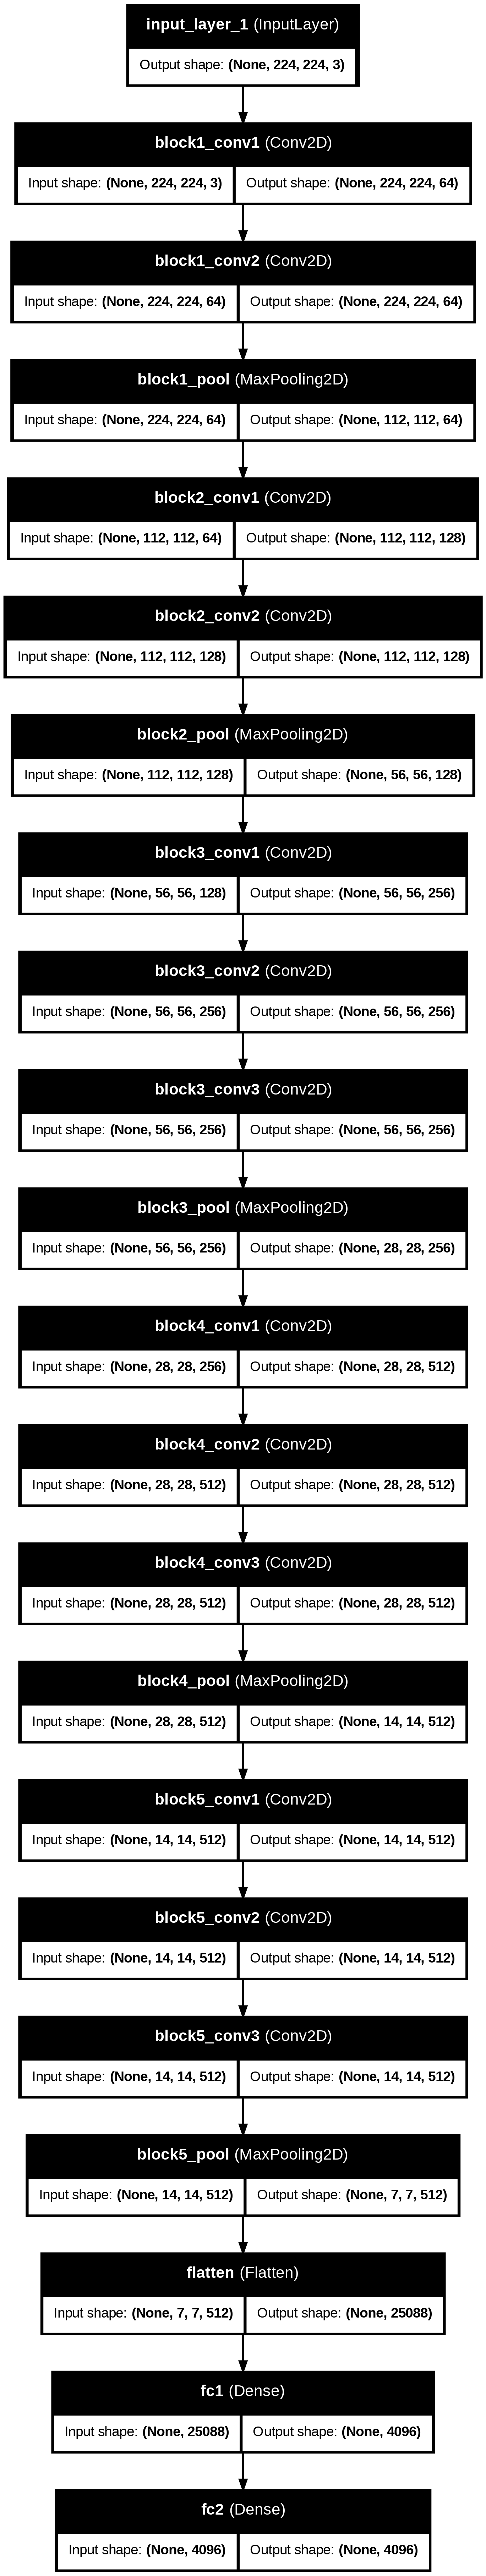

In [ ]:
#Creating the model
model = get_model()     #Calling model function

#Model summary
model.summary()

#Plotting the model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
import os
import cv2

def get_files(path, size):
    fn_imgs = []
    # Ensure path ends with a slash
    if not path.endswith('/'):
        path += '/'

    files = [file for file in os.listdir(path) if file.lower().endswith(('.png', '.jpg', '.jpeg'))]  # Filter image files
    for file in files:
        img = cv2.imread(path + file)  # Read the image
        if img is None:
            print(f"Warning: Unable to read file {file}. Skipping.")
            continue  # Skip files that cannot be read
        img_resized = cv2.resize(img, size)  # Resize the image
        fn_imgs.append([file, img_resized])  # Store filename and resized image
    return dict(fn_imgs)

# Example usage:
img_path = r'/content/drive/MyDrive/Glaucoma'  # Path to image dataset
imgs_dict = get_files(path=img_path, size=(224, 224))


In [ ]:
img_feature_vector = feature_vectors(imgs_dict, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 683ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 579ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 605ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 592ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 933ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 989ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 949ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 618ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 604ms/ste

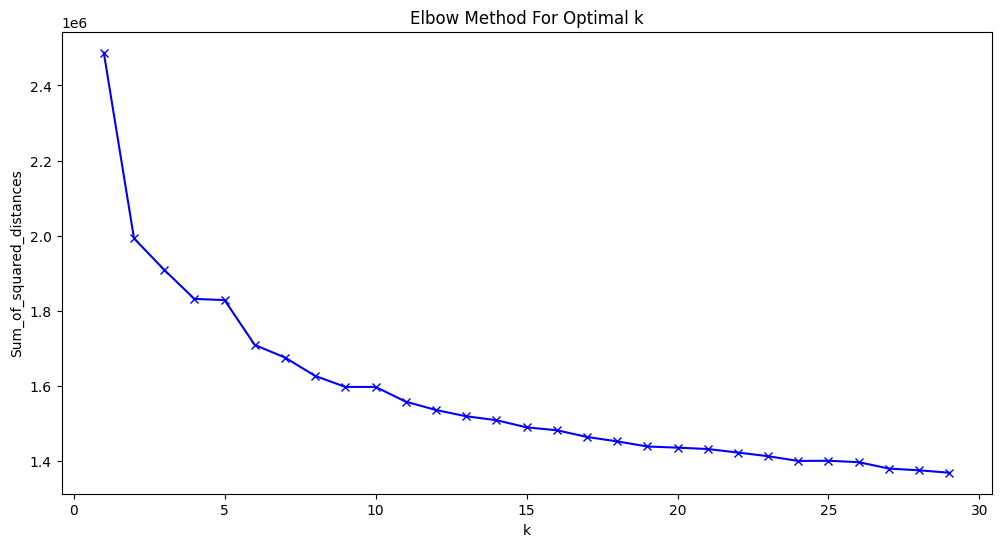

In [ ]:
''' In this code cell we determine the optimal number of clusters to be detected
    in our image dataset. The method used for it is called the elbow method. In
    this method we perform the clustering algorithm for a range of cluster values
    and then calculate the variance in each cluster. The variance is then plotted
    agains the cluster numbers. The point where the curve bends and makes an
    elbow shape is then choosen to be optimal number of clusters since after
    this point the variance decreases very slowly.'''

images = list(img_feature_vector.values())    #Image feature vectors
fns = list(img_feature_vector.keys())         #Image file names
sum_of_squared_distances = []                 #Initializing the variance
K = range(1, 30)                              #Range of clusters to be tried
for k in K:                                   #For loop over the cluster range
    km = KMeans(n_clusters=k)                 #KNN object with cluster number
    km = km.fit(images)                       #Running cluster algorithm
    sum_of_squared_distances.append(km.inertia_)   #Calculating the variance

#Plotting the variance
fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [ ]:
n_runs = 10  # Number of runs to average the score
silhouette_scores = []

for _ in range(n_runs):
    kmeans = KMeans(n_clusters=2, init='k-means++', n_init=10)
    kmeans.fit(images)
    score = silhouette_score(images, kmeans.labels_)
    silhouette_scores.append(score)

average_silhouette_score = np.mean(silhouette_scores)
print(f"Average Silhouette Score: {average_silhouette_score}")

Average Silhouette Score: 0.18934236466884613


In [ ]:
n_runs = 10  # Number of runs to average the score
silhouette_scores = []

for _ in range(n_runs):
    kmeans = KMeans(n_clusters=5, init='k-means++', n_init=10)
    kmeans.fit(images)
    score = silhouette_score(images, kmeans.labels_)
    silhouette_scores.append(score)

average_silhouette_score = np.mean(silhouette_scores)
print(f"Average Silhouette Score: {average_silhouette_score}")


Average Silhouette Score: 0.16523781418800354


In [ ]:
#Running clustering algorithm with optimal number of clusters
n_clusters = 2#Optimal number of clusters
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=n_clusters, init='k-means++', n_init=10, random_state=42)
 #Initializing clustering object
kmeans.fit(images)                     #Fitting the clustering object to the dataset
y_kmeans = kmeans.predict(images)      #Predicting clusters for each image in the dataset
file_names = list(imgs_dict.keys())

In [ ]:
import os
import cv2

cluster_path = img_path + '/'  # Ensure trailing slash for proper path
path_to_files = img_path + '/'  # Ensure trailing slash for proper path

# Ensure each cluster directory exists
for c in range(n_clusters):
    cluster_dir = cluster_path + 'cluster_' + str(c) + '/'
    if not os.path.exists(cluster_dir):
        os.makedirs(cluster_dir)

# Store each image in its respective cluster directory
for fn, cluster in zip(file_names, y_kmeans):
    full_path = path_to_files + fn  # Full path to the image
    image = cv2.imread(full_path)
    if image is None:
        print(f"Warning: Could not read file {full_path}. Skipping.")
        continue
    save_path = cluster_path + 'cluster_' + str(cluster) + '/' + fn
    cv2.imwrite(save_path, image)


For n_clusters = 2 The average silhouette_score is : 0.1879061


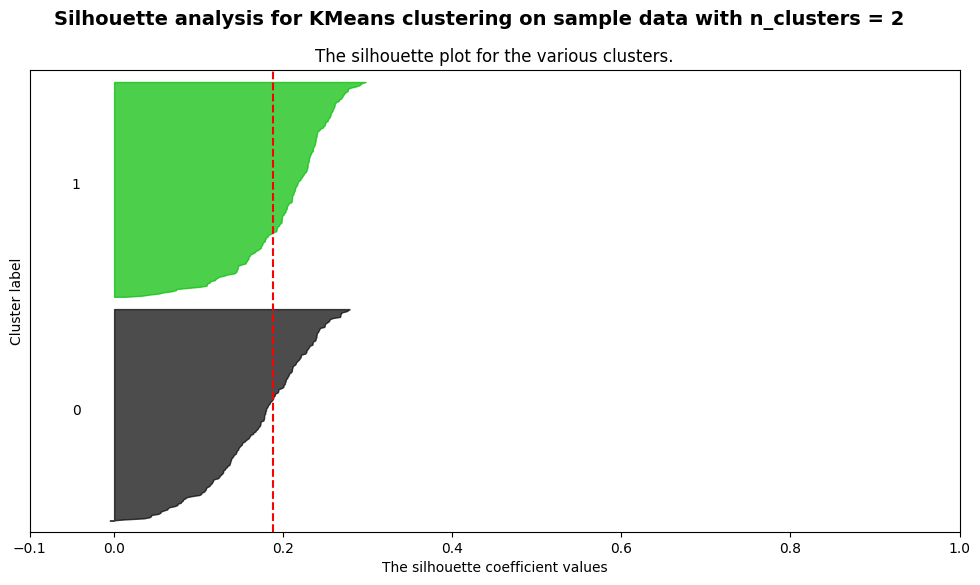

In [ ]:
'''In this cell code we evaluate the performance of our clustering algorithm.
   since clustering is an unsupervised learning technique, thus there is no
   direct method to evaluate its performance since we dont have the ground truth
   available. The performance metric used here is called the silhouette analysis.
   It is basically a measure of how similar the members in the same cluster are
   and how different they are from the neighbour clusters.'''

fig, ax = plt.subplots(figsize=(12, 6))        #Empty figure

# The silhouette coefficient can range from -1, 1 but in this example all
# lie within [-0.1, 0.5]
ax.set_xlim([-0.1, 0.5])                               #X-axis limit
ax.set_ylim([0, len(images) + (n_clusters + 1) * 10])  #Y-axis limit

# Compute the silhouette scores for each image
sample_silhouette_values = silhouette_samples(images, y_kmeans)
# Compute the average silhouette score
silhouette_avg = silhouette_score(images, y_kmeans)

y_lower = 10
#For loop over each image in the respective cluster
for i in range(n_clusters):
  # Aggregate the silhouette scores for samples belonging to
  # cluster i, and sort them
  ith_cluster_silhouette_values = \
      sample_silhouette_values[y_kmeans == i]

  ith_cluster_silhouette_values.sort() #Sorting each cluster score

  #Setting limit for each cluster in y-axis
  size_cluster_i = ith_cluster_silhouette_values.shape[0]
  y_upper = y_lower + size_cluster_i

  #Setting color for each cluster's silhouette coefficients
  color = cm.nipy_spectral(float(i) / n_clusters)
  ax.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

  # Label the silhouette plots with their cluster numbers at the middle
  ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

  # Compute the new y_lower for next plot
  y_lower = y_upper + 10  # 10 for the 0 samples

#Titles for the plot
ax.set_title("The silhouette plot for the various clusters.")
ax.set_xlabel("The silhouette coefficient values")
ax.set_ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
ax.axvline(x=silhouette_avg, color="red", linestyle="--")

ax.set_yticks([])  # Clear the yaxis labels / ticks
ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold');

#Printing the average silhouette score for the clusters
print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

Total images in cluster_0/: 819


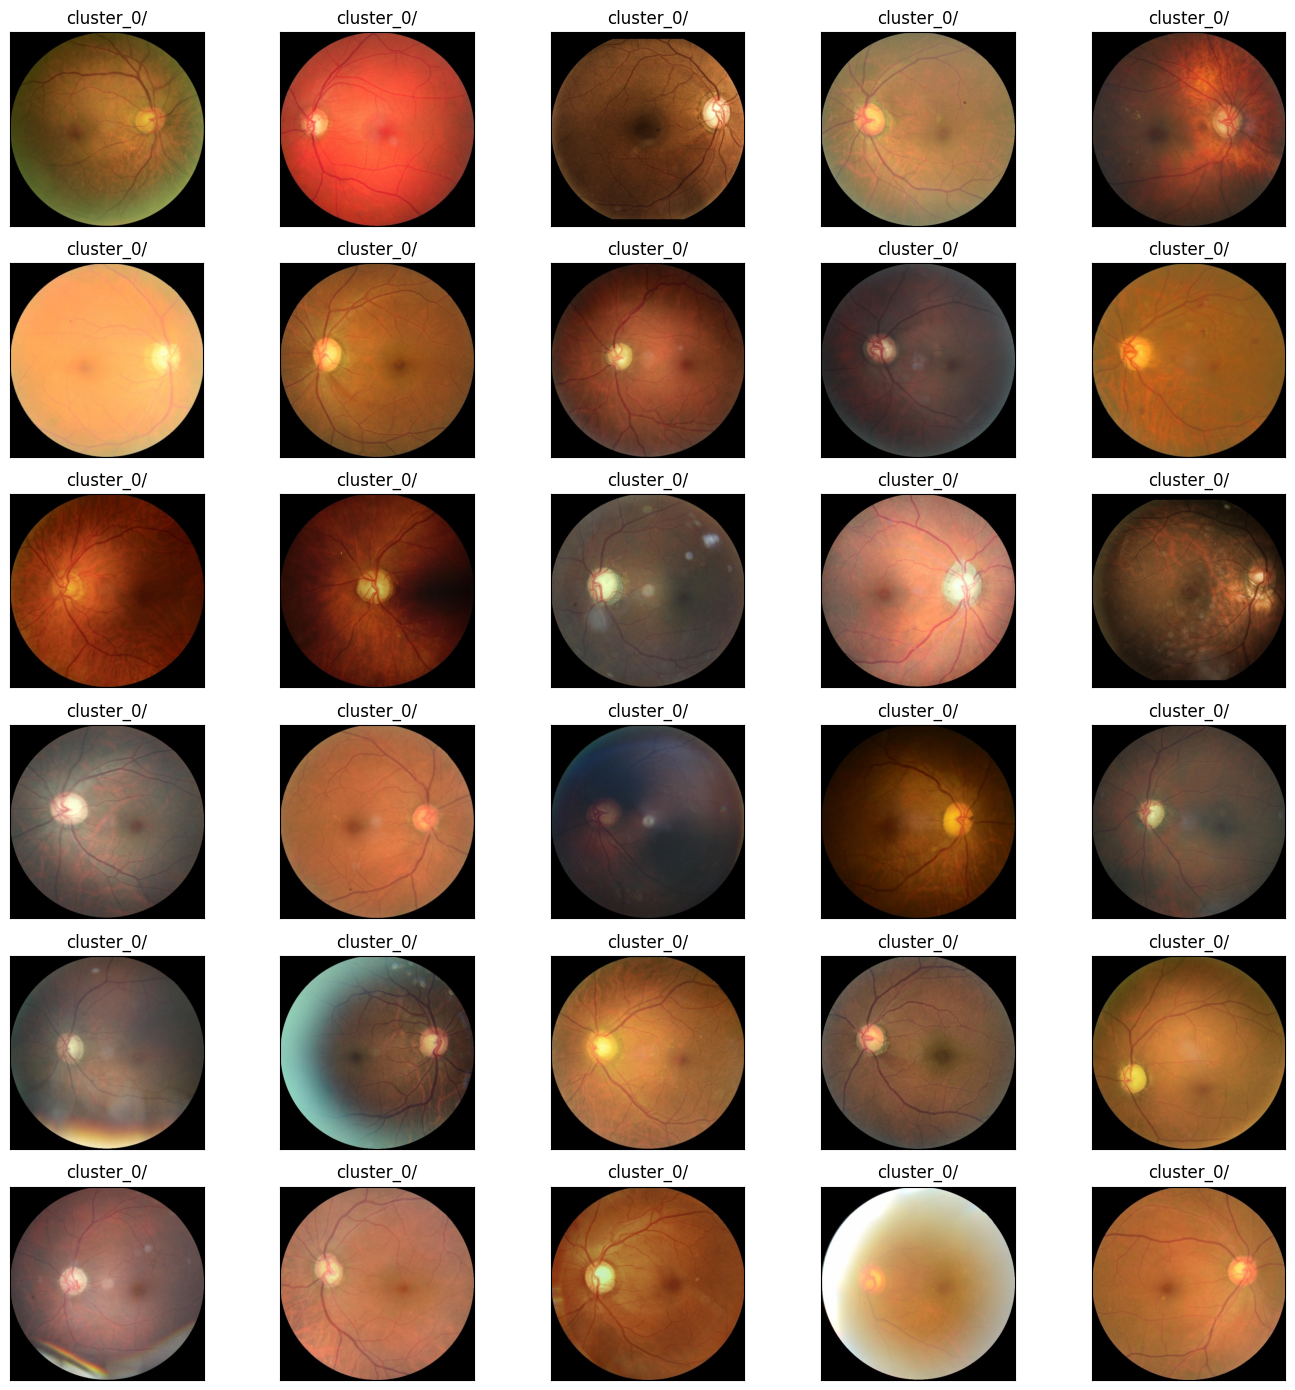

In [ ]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Plotting images in each cluster
fig = plt.figure(figsize=(14, 14))  # Empty figure

cluster_no = 'cluster_0/'  # Cluster number to be plotted

cluster_path = img_path + '/' + cluster_no  # Ensure proper path to specified cluster images
if not os.path.exists(cluster_path):
    print(f"Cluster path '{cluster_path}' does not exist.")
else:
    images = [file for file in os.listdir(cluster_path) if file.lower().endswith(('.png', '.jpg', '.jpeg'))]  # Filter image files

    for cnt, data in enumerate(images[:30]):  # For loop over the first 30 images in the cluster
        y = fig.add_subplot(6, 5, cnt + 1)  # Creating subplots
        img = mpimg.imread(os.path.join(cluster_path, data))  # Reading the image
        y.imshow(img)  # Plotting the image
        plt.title(cluster_no)  # Cluster number as a title over the image
        y.axes.get_xaxis().set_visible(False)
        y.axes.get_yaxis().set_visible(False)

    cluster0_imgs_total = len(images)  # Total number of images in the cluster
    print(f"Total images in {cluster_no}: {cluster0_imgs_total}")
    plt.tight_layout()
    plt.show()


Total images in cluster_1/: 681


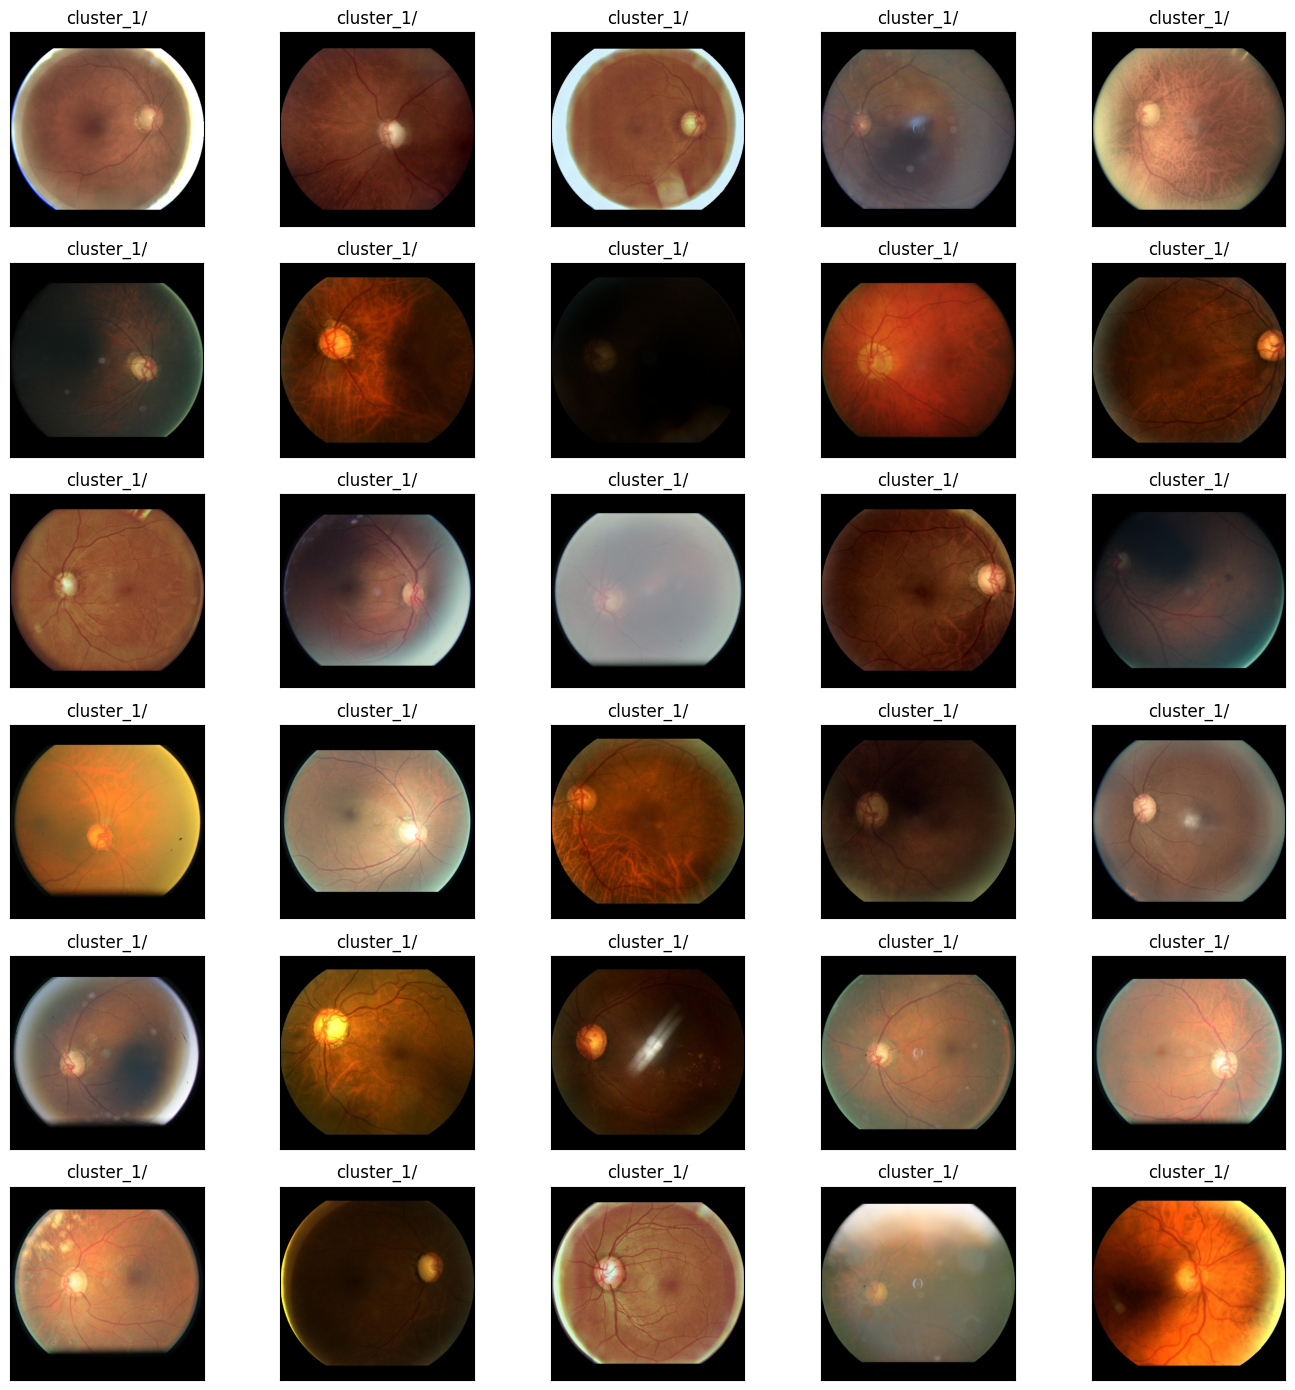

In [ ]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Plotting images in each cluster
fig = plt.figure(figsize=(14, 14))  # Empty figure

cluster_no = 'cluster_1/'  # Cluster number to be plotted

cluster_path = img_path + '/' + cluster_no  # Ensure proper path to specified cluster images
if not os.path.exists(cluster_path):
    print(f"Cluster path '{cluster_path}' does not exist.")
else:
    images = [file for file in os.listdir(cluster_path) if file.lower().endswith(('.png', '.jpg', '.jpeg'))]  # Filter image files

    for cnt, data in enumerate(images[:30]):  # For loop over the first 30 images in the cluster
        y = fig.add_subplot(6, 5, cnt + 1)  # Creating subplots
        img = mpimg.imread(os.path.join(cluster_path, data))  # Reading the image
        y.imshow(img)  # Plotting the image
        plt.title(cluster_no)  # Cluster number as a title over the image
        y.axes.get_xaxis().set_visible(False)
        y.axes.get_yaxis().set_visible(False)

    cluster1_imgs_total = len(images)  # Total number of images in the cluster
    print(f"Total images in {cluster_no}: {cluster1_imgs_total}")
    plt.tight_layout()
    plt.show()


In [ ]:
img_total = len(img_feature_vector)    #Total number of images in the dataset

percent_dup_removed = (1-(n_clusters/img_total))*100     #Percent duplication removed


# Creating dataset
Clusters_t = ['Cluster_0', 'Cluster_1']

p_d_c0 = (cluster0_imgs_total/img_total)*percent_dup_removed       #Percent duplication in cluster0
p_d_c1 = (cluster1_imgs_total/img_total)*percent_dup_removed       #Percent duplication in cluster1

        #Percent duplication in cluster2
      #Percent duplication in cluster0


table = [['Category', 'Images', 'Duplication (%)'], ['Cluster_0', str(cluster0_imgs_total), p_d_c0],
 ['Cluster_1', str(cluster1_imgs_total), p_d_c1],


         ['Total', str(img_total), percent_dup_removed]]

print('The details of overall duplication percentage and per are presented in the below table')
print(tabulate(table, headers='firstrow', tablefmt='grid'))

The details of overall duplication percentage and per are presented in the below table
+------------+----------+-------------------+
| Category   |   Images |   Duplication (%) |
+============+==========+===================+
| Cluster_0  |      819 |           54.5272 |
+------------+----------+-------------------+
| Cluster_1  |      681 |           45.3395 |
+------------+----------+-------------------+
| Total      |     1500 |           99.8667 |
+------------+----------+-------------------+


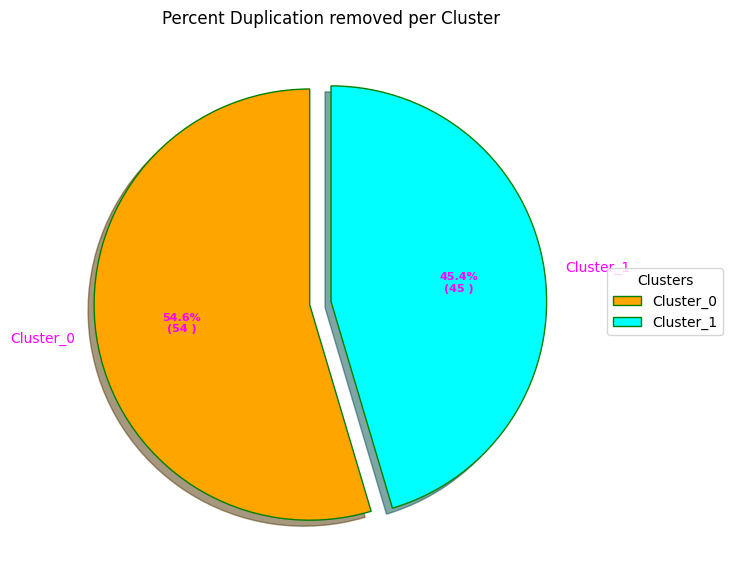

In [ ]:
data = [p_d_c0, p_d_c1]

# Creating explode data
explode = (0.1, 0.0)

# Creating color parameters
colors = ("orange", "cyan")

# Wedge properties
wp = { 'linewidth' : 1, 'edgecolor' : "green" }

# Creating autocpt arguments
def func(pct, allvalues):
    absolute = int(pct / 100.*np.sum(allvalues))
    return "{:.1f}%\n({:d} )".format(pct, absolute)

# Creating plot
fig, ax = plt.subplots(figsize =(10, 7))
wedges, texts, autotexts = ax.pie(data,
                                  autopct = lambda pct: func(pct, data),
                                  explode = explode,
                                  labels = Clusters_t,
                                  shadow = True,
                                  colors = colors,
                                  startangle = 90,
                                  wedgeprops = wp,
                                  textprops = dict(color ="magenta"))

# Adding legend
ax.legend(wedges, Clusters_t,
          title ="Clusters",
          loc ="center left",
          bbox_to_anchor =(1, 0, 0.5, 1))

plt.setp(autotexts, size = 8, weight ="bold")
ax.set_title("Percent Duplication removed per Cluster")

# show plot
plt.show()

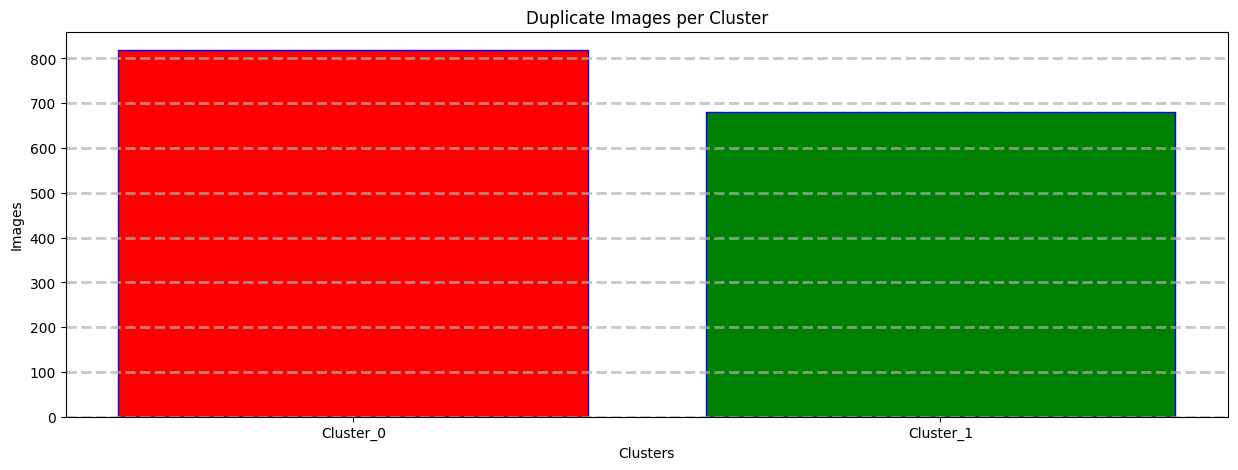

In [ ]:
# create a dataset
height = [cluster0_imgs_total, cluster1_imgs_total]
bars = ('Cluster_0','Cluster_1')
x_pos = np.arange(len(bars))

# Create bars with different colors
fig = plt.figure(figsize=(15, 5))
plt.bar(x_pos, height, color=['red', 'green'],edgecolor='blue')

# Create names on the x-axis
plt.xticks(x_pos, bars)
plt.ylabel('Images')
plt.xlabel('Clusters')
plt.grid( linestyle='--', linewidth=2, axis='y', alpha=0.7)

plt.title('Duplicate Images per Cluster')

# Show graph
plt.show()